#### Imports and fetching data 

In [7]:
import pandas as pd
import sys
import os
import numpy as np
from datetime import timedelta, datetime
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import time

sys.path.append(os.path.abspath("../src"))
from companies import companies

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

holdings = pd.read_excel("../BUFC_May_2025_Allocations.xlsx", sheet_name=0)
holdings = holdings[:-2]
holdings = holdings.drop(holdings.iloc[1].name)
holdings = holdings.drop(holdings.iloc[14].name)
holdings.loc[holdings.index[0], 'Current Price'] = 1.0
holdings.loc[holdings.index[0], 'Current Value'] = holdings.loc[holdings.index[0], 'Total Cost Basis']
holdings.loc[holdings.index[0], 'Average Cost Basis'] = 1.0
holdings = holdings.rename(columns={"Unnamed: 0": "Company"})
holdings["Ticker"] = holdings["Company"].str.extract(r":([A-Z]+)\)")
holdings = holdings.reset_index()
holdings = holdings.drop('index', axis=1)

sector_allocations = pd.read_excel("../BUFC_May_2025_Allocations.xlsx", sheet_name=1) 
sector_allocations.loc[sector_allocations.index[-1], '% of Fund'] = 1.0

In [ ]:
from polygon import RESTClient
from datetime import datetime
from dateutil.relativedelta import relativedelta
import random 
from datetime import timezone
import os

client = RESTClient("apRxKKpQoM2_K8sPhJ5a0IFvs7C0tGs1") # don't share this pls 
start_str = "2025-01-01"
end_str = datetime.today().strftime("%Y-%m-%d")
start_date = pd.to_datetime("2025-01-01")
end_date = datetime.today()

CSV_PATH = "../daily_prices.csv"
prices_data = pd.DataFrame()

if os.path.exists(CSV_PATH):
    prices_data = pd.read_csv(CSV_PATH, parse_dates=["date"])
    prices_data.set_index("date", inplace=True)

REQUEST_LIMIT_PER_MIN = 4
request_count = 0
start_minute = time.time()

for stock in companies:
    
    if stock in prices_data.columns:
        existing_dates = prices_data[stock].dropna().index
        if not existing_dates.empty:
            latest_date = existing_dates.max()
            if pd.to_datetime(latest_date) >= pd.to_datetime(end_str) - pd.Timedelta(days=1):
                print(f"{stock}: up-to-date.")
                continue
            fetch_from_date = latest_date + pd.Timedelta(days=1)
        else:
            fetch_from_date = start_date
    else:
        fetch_from_date = start_date

    fetch_from_str = fetch_from_date.strftime("%Y-%m-%d")

    if fetch_from_date >= end_date:
        print(f"{stock}: no new data needed.")
        continue

    # Respect rate limits
    if request_count >= REQUEST_LIMIT_PER_MIN:
        elapsed = time.time() - start_minute
        if elapsed < 60:
            time.sleep(60 - elapsed)
        start_minute = time.time()
        request_count = 0

    try:
        aggs = client.get_aggs(
            ticker=stock,
            multiplier=1,
            timespan="day",
            from_=fetch_from_str,
            to=end_str,
            adjusted=True,
            sort="asc",
            limit=150
        )

        temp_df = pd.DataFrame([{
            "date": datetime.fromtimestamp(a.timestamp / 1000, tz=timezone.utc).date(),
            stock: a.close
        } for a in aggs])

        if temp_df.empty:
            continue

        temp_df.set_index("date", inplace=True)
        prices_data = prices_data.join(temp_df, how="outer") if not prices_data.empty else temp_df

        print(f"{stock}: fetched {len(temp_df)} new rows.")
        request_count += 1
        time.sleep(1.2)

    except Exception as e:
        print(f"{stock}: failed with error {e}")

PSCI: up-to-date.
PSCT: up-to-date.
PSCM: up-to-date.
PSCU: up-to-date.
RSPG: up-to-date.
RSPF: up-to-date.
MITK: up-to-date.
NXT: up-to-date.
PATK: up-to-date.
PECO: up-to-date.
PUBM: up-to-date.
STEP: up-to-date.
ENSG: up-to-date.
MODG: up-to-date.
WINA: up-to-date.
AGCO: up-to-date.
BMI: up-to-date.
SKY: up-to-date.
CVLT: up-to-date.
EHC: up-to-date.
INMD: up-to-date.
PSR: up-to-date.
KBWR: up-to-date.
PSCC: up-to-date.
PSCH: up-to-date.


In [33]:
CSV_PATH = "../daily_prices.csv"
prices_data.sort_index(inplace=True)
prices_data.to_csv(CSV_PATH)

In [16]:
#define new portfolio df 
columns = ['Ticker', 'shares', 'cost basis', 'current value', 'return', 'weights']
live_portfolio = pd.DataFrame(columns=columns)

latest_prices = prices_data.iloc[-1]

cash_row = holdings.iloc[0]
cash_amount = cash_row["Total Cost Basis"]

live_portfolio.loc[len(live_portfolio)] = [
    "SPAXX",           
    cash_amount,    
    cash_amount,            
    cash_amount,       
    0,                 
    0                   
]

for _, row in holdings.iloc[1:].iterrows(): 
    ticker = row["Ticker"]
    
    shares = row["Total Cost Basis"] / row["Average Cost Basis"]
    cost_basis = row["Total Cost Basis"]
    current_price = latest_prices[ticker]
    current_value = shares * current_price
    ret = (current_value - cost_basis) / cost_basis
    
    live_portfolio.loc[len(live_portfolio)] = [
        ticker, shares, cost_basis, current_value, ret, 0
    ]

portfolio_value = live_portfolio["current value"].sum()
live_portfolio["weights"] = live_portfolio["current value"] / portfolio_value

live_portfolio = live_portfolio.sort_values("weights", ascending=False).reset_index(drop=True)

#### Live portfolio analysis 

In [17]:
live_portfolio

,Ticker,shares,cost basis,current value,return,weights
0,PSCT,2865.00,136144.80,134155.91700,-0.014609,0.113015
1,PSCI,933.00,86489.10,128565.25410,0.486491,0.108305
2,STEP,1495.00,44431.40,89161.80000,1.006729,0.075111
3,KBWR,1226.00,70776.98,73523.46520,0.038805,0.061937
4,SPAXX,66121.67,66121.67,66121.67000,0.000000,0.055702
5,PSCH,1680.00,69720.00,66094.72800,-0.051998,0.055679
6,PSR,616.00,54904.08,56661.71280,0.032013,0.047732
7,RSPF,744.00,37051.20,56529.12000,0.525703,0.047621
8,RSPG,650.00,44167.50,48535.50000,0.098896,0.040887
9,EHC,425.00,41824.25,46716.00000,0.116960,0.039354


In [18]:
print(f"Total portfolio value as of 07-17-2025: ${portfolio_value:,.2f}")

Total portfolio value as of 07-17-2025: $1,187,068.16


In [19]:
client = RESTClient("apRxKKpQoM2_K8sPhJ5a0IFvs7C0tGs1") # don't share this pls 
start_str = "2025-01-01"
end_str = datetime.today().strftime("%Y-%m-%d")


aggs = client.get_aggs(
    ticker="IWM",
    multiplier=1,
    timespan="day",
    from_=start_str,
    to=end_str,
    adjusted=True,
    sort="asc",
    limit=300
)

rut_df = pd.DataFrame([{
    "date": pd.to_datetime(a.timestamp, unit="ms"),
    "IWM": a.close
} for a in aggs])

rut_df['date'] = pd.to_datetime(rut_df['date'])
rut_df.set_index('date', inplace=True)
rut_df.rename(columns={'IWM': 'price'}, inplace=True)
rut_series = rut_df['price']

In [20]:
tickers = list(prices_data.columns)  # use all tickers, including index ETFs

prices_data.index = pd.to_datetime(prices_data.index).normalize()
rut_series.index = pd.to_datetime(rut_series.index).normalize()

portfolio_returns = prices_data.pct_change().mean(axis=1)
benchmark_returns = rut_series.pct_change()
excess_returns = portfolio_returns - benchmark_returns

portfolio_cum = (1 + portfolio_returns.fillna(0)).cumprod()
benchmark_cum = (1 + benchmark_returns.fillna(0)).cumprod()
alpha_line = portfolio_cum - benchmark_cum

rolling_alpha = excess_returns.rolling(30).mean()

sectors = {'PSCI':'Index', 'PSCT':'Index', 'PSCM':'Index', 'PSCU':'Index',
        'RSPG':'Index', 'RSPF':'Index', 'MITK':'Tech','NXT':'Tech', 'PATK':
        'Industrials', 'PECO':'Real Estate', 'PUBM':'Tech', 'STEP':'Financial',
        'ENSG':'Healthcare', 'MODG':'Consumer','WINA':'Consumer', 'AGCO':'Industrials',
        'BMI':'Industrials', 'SKY':'Consumer', 'CVLT':'Tech', 'EHC':'Healthcare',
        'INMD':'Healthcare', 'PSR':'Index', 'KBWR':'Index', 'PSCC':'Index', 'PSCH':'Index'}

sector_map = {ticker: sectors[ticker] for ticker in tickers}
sector_excess = prices_data[tickers].pct_change().sub(benchmark_returns, axis=0)
sector_contributions = sector_excess.mean().groupby(sector_map).sum()

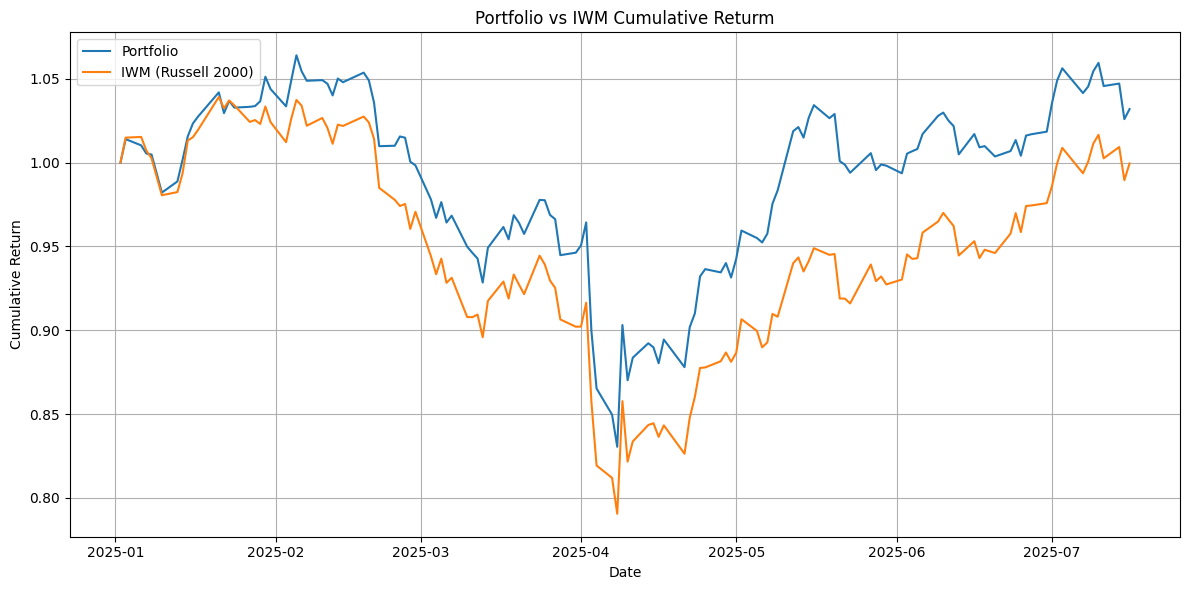

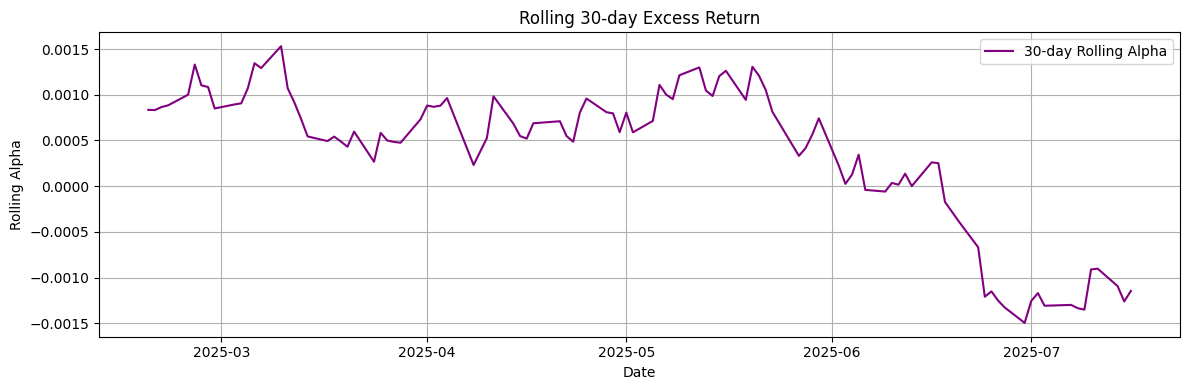

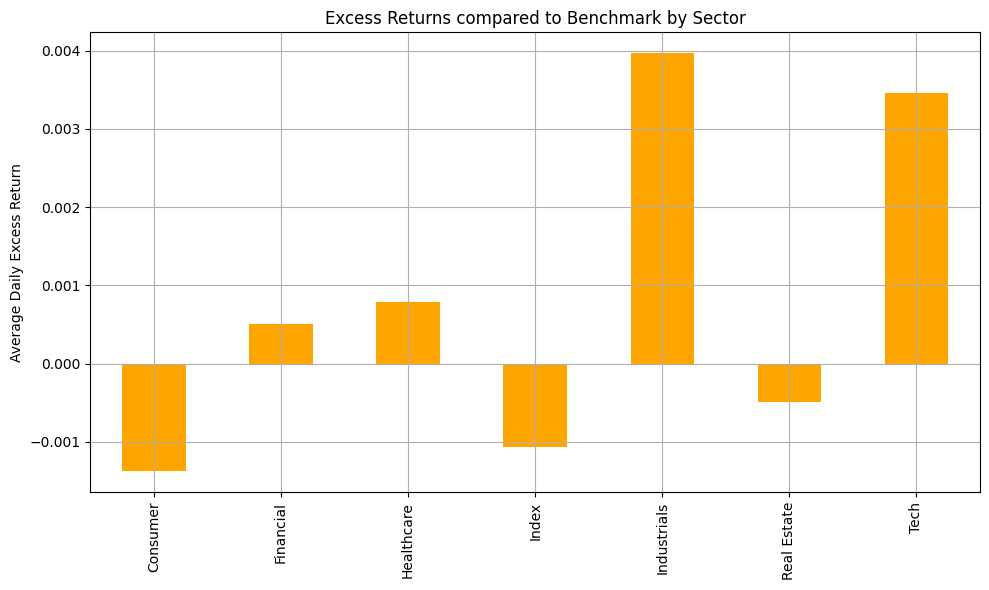

In [26]:
# Portfolio vs Benchmark with Alpha
plt.figure(figsize=(12, 6))
plt.plot(portfolio_cum, label='Portfolio')
plt.plot(benchmark_cum, label='IWM (Russell 2000)')
plt.title('Portfolio vs IWM Cumulative Returm')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Rolling Alpha Plot
plt.figure(figsize=(12, 4))
plt.plot(rolling_alpha, label='30-day Rolling Alpha', color='purple')
plt.title('Rolling 30-day Excess Return')
plt.xlabel('Date')
plt.ylabel('Rolling Alpha')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Alpha Attribution Bar Chart
plt.figure(figsize=(10, 6))
sector_contributions.plot(kind='bar', color='orange')
plt.title('Excess Returns compared to Benchmark by Sector')
plt.ylabel('Average Daily Excess Return')
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/2k/37z1zz6n3xb3d2l8yb7lv62h0000gn/T/ipykernel_88047/1884171338.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_alpha = alpha_line.resample('M').last() - alpha_line.resample('M').first()


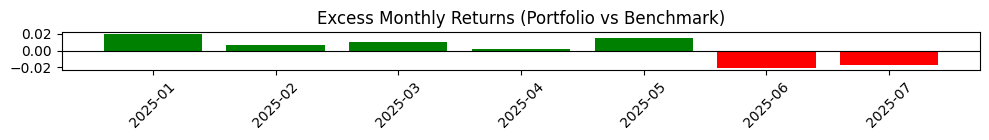

In [ ]:
monthly_alpha = alpha_line.resample('M').last() - alpha_line.resample('M').first()
monthly_alpha.index = monthly_alpha.index.strftime('%Y-%m')

# Convert to DataFrame for heatmap-like display
alpha_df = pd.DataFrame(monthly_alpha, columns=['Alpha'])

plt.figure(figsize=(10, 1.5))
colors = alpha_df['Alpha'].apply(lambda x: 'green' if x > 0 else 'red')
plt.bar(alpha_df.index, alpha_df['Alpha'], color=colors)
plt.axhline(0, color='black', linewidth=0.8)
plt.xticks(rotation=45)
plt.title('Excess Monthly Returns (Portfolio vs Benchmark)')
plt.tight_layout()
plt.show()
# comment

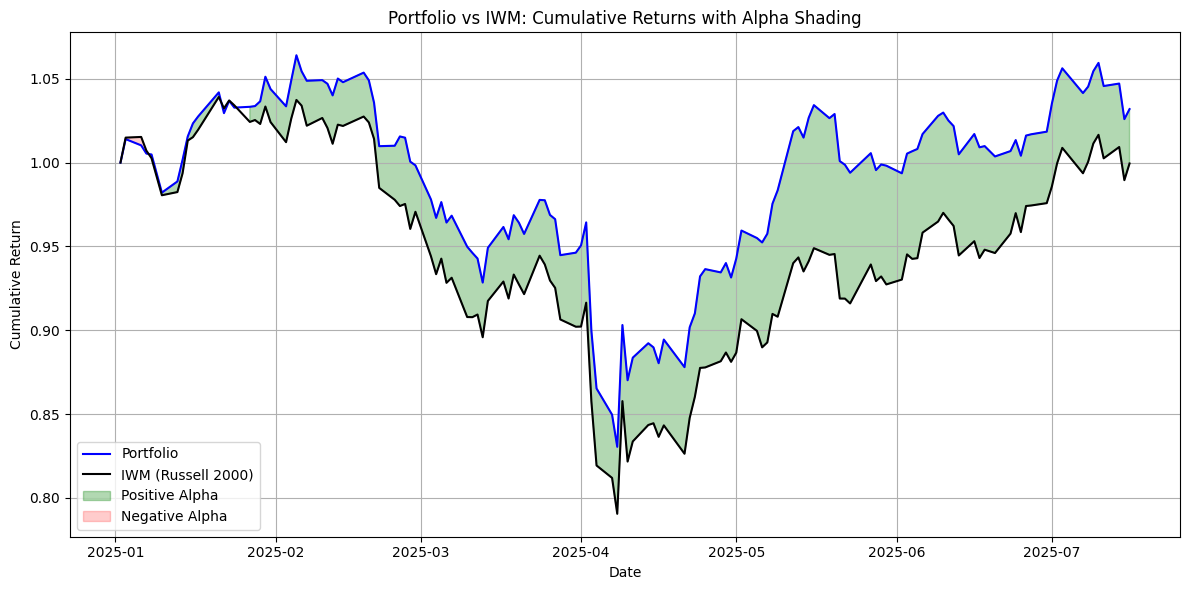

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(portfolio_cum, label='Portfolio', color='blue')
plt.plot(benchmark_cum, label='IWM (Russell 2000)', color='black')

# Fill the area between the portfolio and benchmark
plt.fill_between(portfolio_cum.index, portfolio_cum, benchmark_cum,
                 where=(portfolio_cum > benchmark_cum),
                 color='green', alpha=0.3, label='Positive Alpha')
plt.fill_between(portfolio_cum.index, portfolio_cum, benchmark_cum,
                 where=(portfolio_cum <= benchmark_cum),
                 color='red', alpha=0.2, label='Negative Alpha')

plt.title('Portfolio vs IWM: Cumulative Returns with Alpha Shading')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/2k/37z1zz6n3xb3d2l8yb7lv62h0000gn/T/ipykernel_88047/2296781812.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  betas[ticker] = model.params[1]
/var/folders/2k/37z1zz6n3xb3d2l8yb7lv62h0000gn/T/ipykernel_88047/2296781812.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  betas[ticker] = model.params[1]
/var/folders/2k/37z1zz6n3xb3d2l8yb7lv62h0000gn/T/ipykernel_88047/2296781812.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

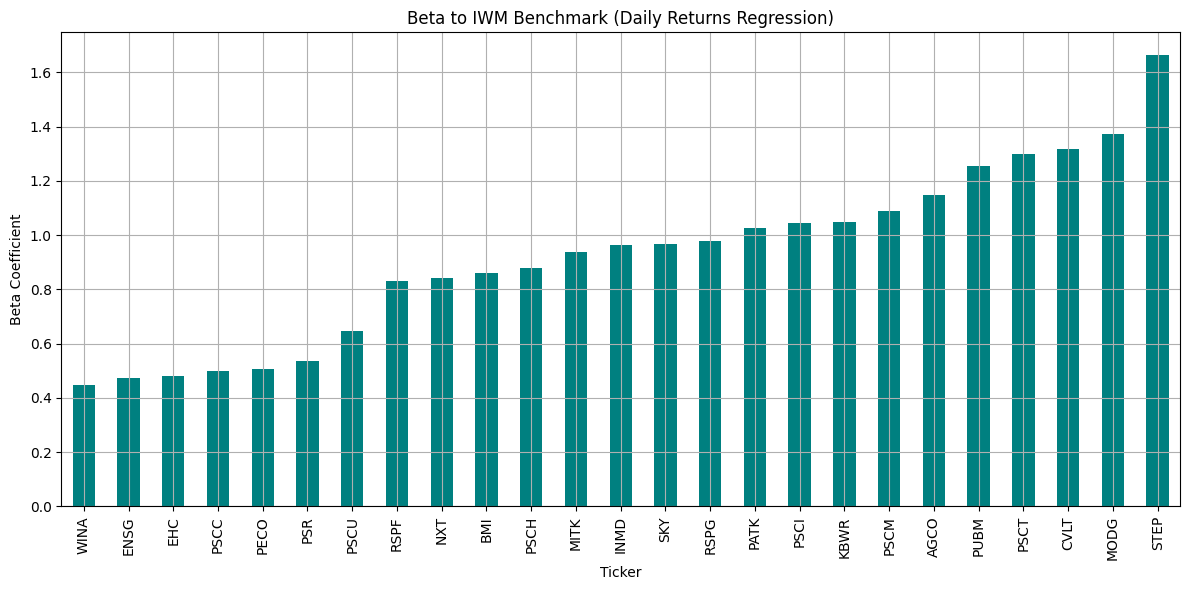

In [24]:
import statsmodels.api as sm

returns = prices_data.pct_change()
benchmark_returns = rut_series.pct_change()

returns = returns.loc[benchmark_returns.index]
benchmark_returns = benchmark_returns.loc[returns.index]

index_tickers = {'PSCI', 'PSCT', 'PSCM', 'PSCU', 'RSPG', 'RSPF', 'PSR', 'KBWR', 'PSCC', 'PSCH'}
bar_colors = 'teal'

betas = {}

for ticker in returns.columns:
    X = sm.add_constant(benchmark_returns)  # adds alpha
    y = returns[ticker]
    model = sm.OLS(y, X, missing='drop').fit()
    betas[ticker] = model.params[1]

beta_df = pd.Series(betas).sort_values()

plt.figure(figsize=(12, 6))
beta_df.plot(kind='bar', color=bar_colors)
plt.title('Beta to IWM Benchmark (Daily Returns Regression)')
plt.ylabel('Beta Coefficient')
plt.xlabel('Ticker')
plt.grid(True)
plt.tight_layout()
plt.show()


#### Other ideas: 

Add metrics for Factor risk exposure, overall portfolio risk, optimal position sizing 
Indifference to index weightings → only investment attractiveness should matter  
